In [1]:
import sys
import os
from time import time

import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from skimage import io as sio
from skimage import measure
from scipy.optimize import linear_sum_assignment

sys.path.insert(0, os.path.abspath('..'))

from src.utils.load_cfg import ConfigLoader
from src.factories import ModelFactory
from src.factories import DatasetFactory
from src.utils.misc import MiscUtils
from src.models.pytorch_ssim.ssim import SSIM

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid', {'axes.grid': False})

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset_cfg = '../configs/dataset_cfgs/epickitchens_short.yaml'
train_cfg = '../configs/train_cfgs/train_san_freeze_short.yaml'

model_cfg = '../configs/model_cfgs/pipeline6_rgbspec_san19pairfreeze_halluconv2_actreggru2_top3_cat.yaml'

In [2]:
# Deprocess data for visualization
def deprocess_rgb(rgb, num_segments):
    rgb = rgb.cpu().numpy()
    assert rgb.shape[0] == 1
    _, _, h, w = rgb.shape
    rgb = rgb.reshape([num_segments, 3, h, w]).transpose(0, 2, 3, 1)
    rgb *= 1  # std
    rgb += np.array([104, 117, 128])  # mean
    rgb = rgb.astype(np.uint8)
    return rgb


def deprocess_flow(flow, num_segments, new_length):
    flow = flow.cpu().numpy()
    assert flow.shape[0] == 1
    _, _, h, w = flow.shape
    flow = flow.reshape([num_segments, new_length, 2, h, w])
    flow *= 1  # std
    flow += 128  # mean
    flow = flow.astype(np.uint8)
    flow_x = flow[:, :, 0, :, :]
    flow_y = flow[:, :, 1, :, :]
    return flow_x, flow_y


def deprocess_spec(spec, num_segments):
    spec = spec.cpu().numpy()
    assert spec.shape[0] == 1
    _, _, h, w = spec.shape
    spec = spec.reshape([num_segments, h, w])
    return spec


def display_input(sample, num_segments):
    # Deprocess inputs
    rgb = deprocess_rgb(sample['RGB'], num_segments)
    spec = deprocess_spec(sample['Spec'], num_segments)

    # Display input RGB
    fig, axes = plt.subplots(1, num_segments, figsize=(3*num_segments, 5))
    fig.suptitle('='*30+'\n  RGB\n'+'='*30, fontsize=15)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    for i in range(num_segments):
        axes[i].imshow(cv2.cvtColor(rgb[i], cv2.COLOR_BGR2RGB))
        axes[i].axis('off')

    # Display input Spec
    fig, axes = plt.subplots(1, num_segments, figsize=(3*num_segments, 5))
    fig.suptitle('='*30+'\n  Spec\n'+'='*30, fontsize=15)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    for i in range(num_segments):
        axes[i].imshow(spec[i], cmap='viridis')
        axes[i].axis('off')

In [3]:
# Load configurations
model_name, model_params = ConfigLoader.load_model_cfg(model_cfg)
# model_params['num_segments'] = 25
dataset_name, dataset_params = ConfigLoader.load_dataset_cfg(dataset_cfg)
train_params = ConfigLoader.load_train_cfg(train_cfg)

dataset_params.update({
    'modality': model_params['modality'],
    'num_segments': model_params['num_segments'],
    'new_length': model_params['new_length'],
})

for k in ['low_feat_model_cfg', 'high_feat_model_cfg', 'hallu_model_cfg', 'actreg_model_cfg',
          'spatial_sampler_cfg', 'temporal_sampler_cfg',
          'hallu_pretrained_weights', 'actreg_pretrained_weights']:
    model_params[k] = '../'+model_params[k]

# Build model
model_factory = ModelFactory()
model = model_factory.generate(model_name, device=device, model_factory=model_factory, **model_params)
model = model.to(device)
model.eval()

# Get training augmentation and transforms
train_augmentation = MiscUtils.get_train_augmentation(model.modality, model.crop_size)
train_transform, val_transform = MiscUtils.get_train_val_transforms(
    modality=model.modality,
    input_mean=model.input_mean,
    input_std=model.input_std,
    scale_size=model.scale_size,
    crop_size=model.crop_size,
    train_augmentation=train_augmentation,
)

# Data loader
dataset_factory = DatasetFactory()
loader_params = {
    'batch_size': train_params['batch_size'],
    'num_workers': train_params['num_workers'],
    'pin_memory': True,
}

val_dataset = dataset_factory.generate(dataset_name, mode='val', transform=val_transform, **dataset_params)
val_loader = DataLoader(val_dataset, shuffle=False, **loader_params)

In [4]:
def plot_img_attn_hallu(sample_id, save=False):
    # Get a sample
    sample, _ = val_loader.dataset[sample_id]
    sample = {k: v.unsqueeze(dim=0).to(device) for k, v in sample.items()}
    
    # Forward
    rgb_high = sample['RGB']
    rgb_low = rgb_high[:, :, ::2, ::2]
    spec = sample['Spec']

    rgb_low = rgb_low.view((-1, model.num_segments, 3) + rgb_low.size()[-2:])[0]
    rgb_high = rgb_high.view((-1, model.num_segments, 3) + rgb_high.size()[-2:])[0]
    spec = spec.view((-1, model.num_segments, 1) + spec.size()[-2:])[0]

    with torch.no_grad():
        # Attention
        model.low_feat_model.rgb(rgb_low)
        attn = model.low_feat_model.rgb.get_attention_weight(
            l_name=model.attention_layer[0],
            m_name=model.attention_layer[1],
            aggregated=True,
            )

        # Hallucination
        hallu, _ = model.hallu_model(attn.unsqueeze(dim=0), None)
        hallu = hallu[0]

        # Bboxes
        bboxes = model.spatial_sampler.sample_multiple_frames(
            attn.unsqueeze(dim=0), rgb_high.shape[-1], reorder=True, avg_across_time=True)[0]

    ssim_criterion = SSIM(window_size=3, channel=attn.shape[1])
    attn = attn.cpu().detach().numpy()
    hallu = hallu.cpu().detach().numpy()
    vmin = min(attn.mean(axis=1).min(), hallu.mean(axis=1).min())
    vmax = max(attn.mean(axis=1).max(), hallu.mean(axis=1).max())

    # Visualize
    rgb_low_ = (rgb_low.permute(0, 2, 3, 1).cpu().numpy() + [104, 117, 128]).astype(np.uint8)
    rgb_high_ = (rgb_high.permute(0, 2, 3, 1).cpu().numpy() + [104, 117, 128]).astype(np.uint8)
    # fig, axes = plt.subplots(4, model.num_segments, figsize=(20, 8))
    fig, axes = plt.subplots(3, model.num_segments, figsize=(20, 6))
    for t in range(model.num_segments):
        axes[0, t].imshow(cv2.cvtColor(rgb_low_[t], cv2.COLOR_BGR2RGB))
        axes[1, t].imshow(attn[t].mean(axis=0), vmin=vmin, vmax=vmax)

        if t >= 1:
            axes[2, t].imshow(hallu[t-1].mean(axis=0), vmin=vmin, vmax=vmax)
            ssim = -ssim_criterion(torch.Tensor(attn[t]).unsqueeze(dim=0),
                                   torch.Tensor(hallu[t-1]).unsqueeze(dim=0)).item()
            axes[2, t].set_xlabel('{:.03f}'.format(ssim), fontsize=12)

    #     foo = cv2.cvtColor(rgb_high_[t], cv2.COLOR_BGR2RGB)
    #     for k in range(3):
    #         bar = bboxes[t, k]
    #         foo[bar[0]:bar[2], bar[1]:bar[3], k] = 255
    #     axes[3, t].imshow(foo)

    for ax in axes.ravel():
        ax.set_xticks([])
        ax.set_yticks([])

    if save:
        fig.savefig('attn_hallu_{}.pdf'.format(sample_id), bbox_inches='tight')

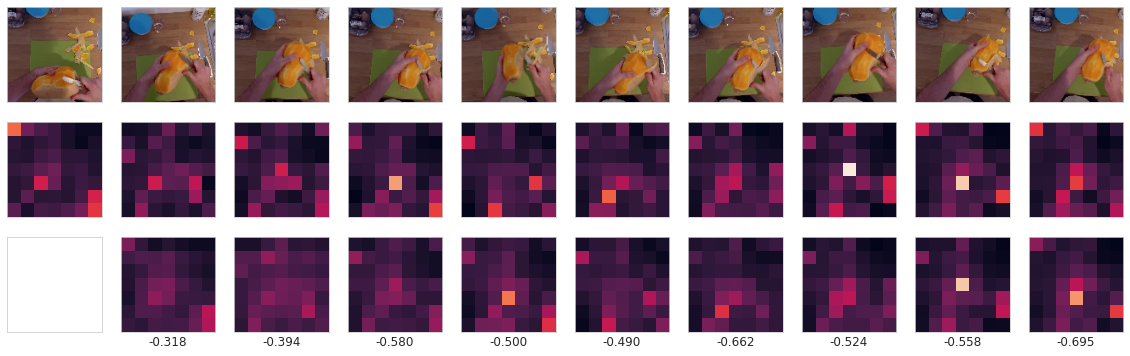

In [5]:
sample_id = 64
plot_img_attn_hallu(sample_id, save=True)

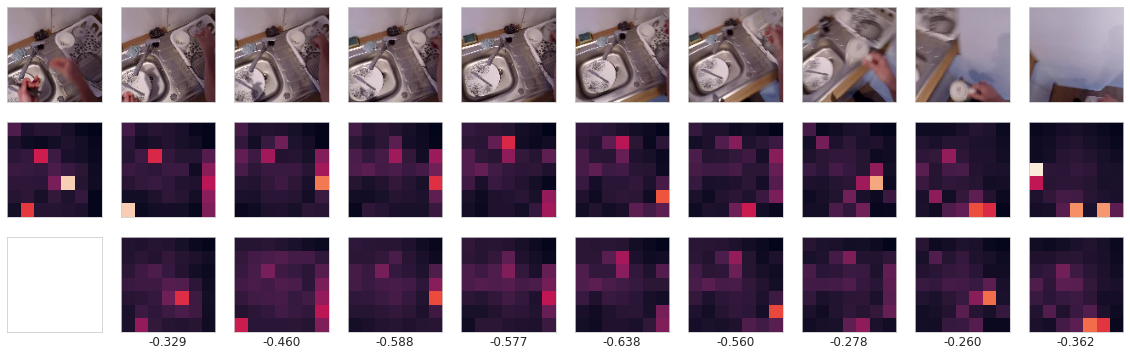

In [6]:
sample_id = 27
plot_img_attn_hallu(sample_id, save=True)

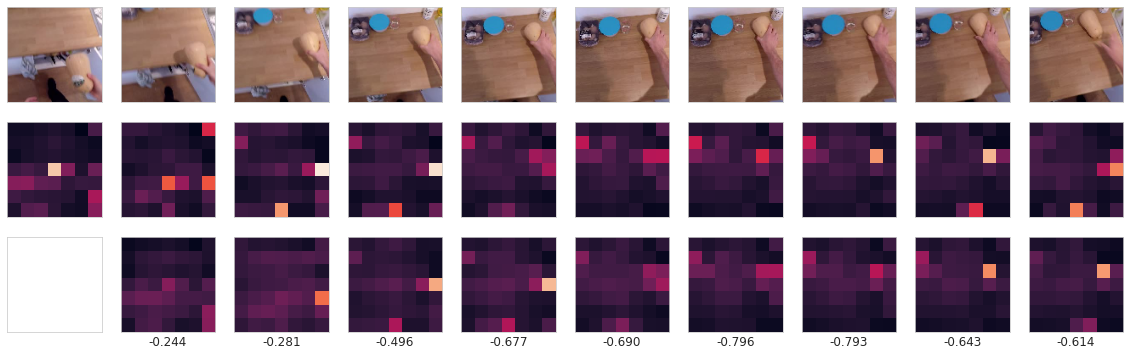

In [8]:
sample_id = 17
plot_img_attn_hallu(sample_id, save=True)